# ALUMNO: Ezequiel Scordamaglia

<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## Predicción de próxima palabra

### Objetivo
El objetivo es utilizar documentos / corpus para crear embeddings de palabras basado en ese contexto utilizando la layer Embedding de Keras. Se utilizará esos embeddings junto con layers LSTM para predeccir la próxima posible palabra.

In [1]:
import random
import io
import pickle

import numpy as np
import pandas as pd

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Dropout, SimpleRNN, GRU
from keras.preprocessing.text import Tokenizer # equivalente a ltokenizer de nltk
from keras.preprocessing.text import text_to_word_sequence # equivalente a word_tokenize de nltk
from keras.utils import pad_sequences # se utilizará para padding


### Datos
Utilizaremos como dataset fragmentos de libros de Borges. (Utilizando datasets tomados de este repositorio: https://github.com/karen-pal/borges/tree/master)

In [2]:
with open('./data/borges_full_texts.pkl', 'rb') as f:
   borges = pickle.load(f)

In [3]:
with open('./data/cortazar_full_texts.pkl', 'rb') as f:
   cortazar = pickle.load(f)

In [4]:
borges.head()

,link,text_metadata,text
0,https://ciudadseva.com/texto/abel-y-cain-borges/,"{'title': 'Abel y Caín', 'metadata': '[Minicue...",Abel y Caín se encontraron después de la muert...
1,https://ciudadseva.com/texto/adrogue/,"{'title': 'Adrogué', 'metadata': '[Minicuento ...","Era muy lindo, un pueblo laberíntico. A veces,..."
2,https://ciudadseva.com/texto/alguien-sonara/,"{'title': 'Alguien soñará', 'metadata': '[Mini...",¿Qué soñará el indescifrable futuro? Soñará qu...
3,https://ciudadseva.com/texto/andres-armoa/,"{'title': 'Andrés Armoa', 'metadata': '[Minicu...",Los años le han dejado unas palabras en guaran...
4,https://ciudadseva.com/texto/argumentum-ornith...,"{'title': 'Argumentum ornithologicum', 'metada...",Cierro los ojos y veo una bandada de pájaros. ...


In [5]:
# Unificar los tres corpus, quedandome solo con la columna text
df = pd.concat([borges, cortazar], axis=0, ignore_index=True)[['text']]
df

,text
0,Abel y Caín se encontraron después de la muert...
1,"Era muy lindo, un pueblo laberíntico. A veces,..."
2,¿Qué soñará el indescifrable futuro? Soñará qu...
3,Los años le han dejado unas palabras en guaran...
4,Cierro los ojos y veo una bandada de pájaros. ...
...,...
112,"Así será algún día su estatua, piensa irónicam..."
113,"Qué le vas a hacer, ñato, cuando estás abajo t..."
114,"Parece una broma, pero somos inmortales. Lo sé..."
115,Al atardecer Florencio bajó con la nena hasta ...


In [6]:
print("Cantidad de documentos:", df.shape[0])

Cantidad de documentos: 117


In [7]:
# Desordenar registros
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [8]:
df

,text
0,"A orillas del Huisne, arroyo de apariencia tra..."
1,Cierro los ojos y veo una bandada de pájaros. ...
2,"Se refiere que a la corte de Olaf Tryggvason, ..."
3,De los muchos problemas que ejercitaron la tem...
4,"En Sumatra, alguien quiere doctorarse de adivi..."
...,...
112,En aquel entonces era difícil saberlo. Uno va ...
113,"Recabarren, tendido, entreabrió los ojos y vio..."
114,No entiendo por qué no me dejan pasar la noche...
115,"Arrasado el jardín, profanados los cálices y l..."


### 1 - Preprocesamiento
- Hay que transformar las oraciones en tokens.
- Dichas oraciones hay que ajustarlas al tamaño fijo de nuestra sentencia de entrada al modelo.
- Hay que separar las palabras objetivos (target) que el modelo debe predecir en cada sentencia armada.

In [9]:

# largo de la secuencia, incluye seq input + word output
train_len = 4
separator_word = 'sep0000'

Debemos transformar ese dataset de filas de oraciones en un texto completo continuo para poder extraer el vocabulario.

In [10]:
# Vistazo a las primeras filas
df.loc[:15]

,text
0,"A orillas del Huisne, arroyo de apariencia tra..."
1,Cierro los ojos y veo una bandada de pájaros. ...
2,"Se refiere que a la corte de Olaf Tryggvason, ..."
3,De los muchos problemas que ejercitaron la tem...
4,"En Sumatra, alguien quiere doctorarse de adivi..."
5,"Dejando de lado los motivos, atengámonos a la ..."
6,"No vamos por el anís, ni porque hay que ir. Ya..."
7,Alcanzándome un programa impreso en papel crem...
8,"Sé que me acusan de soberbia, y tal vez de mis..."
9,La candente mañana de febrero en que Beatriz V...


In [11]:
# Concatenamos todos los rows en un solo valor
# corpus = df.apply(lambda row: ' '.join(row.values.astype(str)), axis=0)[0]
corpus = df['text'].str.cat(sep=' ' + separator_word + ' ')
# corpus

In [12]:
# Transformar el corpus a tokens
tokens=text_to_word_sequence(corpus)
# Vistazo general de los primeros tokens
tokens[:50]

['a',
 'orillas',
 'del',
 'huisne',
 'arroyo',
 'de',
 'apariencia',
 'tranquila',
 'merodeaba',
 'durante',
 'la',
 'edad',
 'media',
 'la',
 'peluda',
 'este',
 'animal',
 'habría',
 'sobrevivido',
 'el',
 'diluvio',
 'sin',
 'haber',
 'sido',
 'recogido',
 'en',
 'el',
 'arca',
 'era',
 'del',
 'tamaño',
 'de',
 'un',
 'toro',
 'tenía',
 'cabeza',
 'de',
 'serpiente',
 'un',
 'cuerpo',
 'esférico',
 'cubierto',
 'de',
 'un',
 'pelaje',
 'verde',
 'armado',
 'de',
 'aguijones',
 'cuya']

In [13]:
print("Cantidad de tokens en el corpus:", len(tokens))

Cantidad de tokens en el corpus: 222859


In [14]:
# Código para hacer el desfasaje de las palabras
# según el train_len
text_sequences = []
for i in range(train_len, len(tokens)):
  seq = tokens[i-train_len:i]
  if separator_word not in seq:
    text_sequences.append(seq)

In [15]:
# Demos un vistazo a nuestros vectores para entrenar el modelo
text_sequences[:20]

[['a', 'orillas', 'del', 'huisne'],
 ['orillas', 'del', 'huisne', 'arroyo'],
 ['del', 'huisne', 'arroyo', 'de'],
 ['huisne', 'arroyo', 'de', 'apariencia'],
 ['arroyo', 'de', 'apariencia', 'tranquila'],
 ['de', 'apariencia', 'tranquila', 'merodeaba'],
 ['apariencia', 'tranquila', 'merodeaba', 'durante'],
 ['tranquila', 'merodeaba', 'durante', 'la'],
 ['merodeaba', 'durante', 'la', 'edad'],
 ['durante', 'la', 'edad', 'media'],
 ['la', 'edad', 'media', 'la'],
 ['edad', 'media', 'la', 'peluda'],
 ['media', 'la', 'peluda', 'este'],
 ['la', 'peluda', 'este', 'animal'],
 ['peluda', 'este', 'animal', 'habría'],
 ['este', 'animal', 'habría', 'sobrevivido'],
 ['animal', 'habría', 'sobrevivido', 'el'],
 ['habría', 'sobrevivido', 'el', 'diluvio'],
 ['sobrevivido', 'el', 'diluvio', 'sin'],
 ['el', 'diluvio', 'sin', 'haber']]

In [17]:
from gensim.models import Word2Vec

# Supongamos que 'sentences' es una lista de listas de palabras
model_w2v = Word2Vec(text_sequences, vector_size=100, window=5, min_count=1, sg=0)

In [18]:
# Tokenizar secuencias de texto usando el modelo de Word2Vec
sequences = []
for line in text_sequences:
  token_list = []
  for word in line:
    try:
      token_list.append(model_w2v.wv.key_to_index[word])
    except:
      token_list.append(0)
  sequences.append(token_list)

# Vistazo a las primeras secuencias
sequences[:10]

[[5, 2772, 13, 7489],
 [2772, 13, 7489, 917],
 [13, 7489, 917, 0],
 [7489, 917, 0, 3591],
 [917, 0, 3591, 1948],
 [0, 3591, 1948, 11947],
 [3591, 1948, 11947, 512],
 [1948, 11947, 512, 1],
 [11947, 512, 1, 1161],
 [512, 1, 1161, 462]]

In [19]:
print("Cantidad de rows del dataset:", len(sequences))

Cantidad de rows del dataset: 222391


### 3 - Input y target

In [20]:
arr_sequences = np.array(sequences)
x_data = arr_sequences[:,:-1]
y_data_int = arr_sequences[:,-1] # aún falta el oneHotEncoder

print(x_data.shape)
print(y_data_int.shape)

(222391, 3)
(222391,)


In [21]:
# Cantidad de palabras en el vocabulario segun model_w2v
vocab_size = len(model_w2v.wv)
vocab_size

25652

In [24]:
# Transformar los datos a oneHotEncoding
y_data = to_categorical(y_data_int, num_classes=vocab_size)

In [25]:
y_data.shape

(222391, 25652)

### 4 - Entrenar el modelo

In [26]:
x_data

array([[   5, 2772,   13],
       [2772,   13, 7489],
       [  13, 7489,  917],
       ...,
       [  11,  107,    0],
       [ 107,    0,    1],
       [   0,    1,   99]])

In [27]:
y_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [28]:
# largo de la secuencia de entrada
input_seq_len = x_data.shape[1] 
input_seq_len

3

In [29]:
# Largo del vector de salida --> vocab_size
output_size = vocab_size
output_size

25652

In [26]:
# # Si existe modelo previo, cargarlo. Buscar en path ./models/modelo_borges_cortazar_0.088.pkl
# import os

# if os.path.isfile('./models/modelo_borges_cortazar_0.088.pkl'):
#    model = pickle.load(open('./models/modelo_borges_cortazar_0.088.pkl', 'rb'))

# if os.path.isfile('./models/tokenizer_borges_cortazar_0.088.pkl'):
#    tok = pickle.load(open('./models/tokenizer_borges_cortazar_0.088.pkl', 'rb'))


In [31]:
# Crear modelo con Keras optimizado para un vocabulario de 25000 palabras y 222391 secuencias de entrada
model = Sequential()
model.add(Embedding(input_dim=len(model_w2v.wv.index_to_key), output_dim=100, input_length=input_seq_len, weights=[model_w2v.wv.vectors], trainable=False))
model.add(GRU(256, return_sequences=True))
model.add(GRU(128))
model.add(Dropout(0.2))
model.add(Dense(150, activation='relu'))
model.add(Dense(output_size, activation='softmax'))

# Compilar el modelo
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 3, 100)            2565200   
                                                                 
 gru_2 (GRU)                 (None, 3, 256)            274944    
                                                                 
 gru_3 (GRU)                 (None, 128)               148224    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 150)               19350     
                                                                 
 dense_3 (Dense)             (None, 25652)             3873452   
                                                                 
Total params: 6881170 (26.25 MB)
Trainable params: 431

In [34]:
# Entrenar el modelo
hist = model.fit(x_data, y_data, batch_size=128, validation_split=0.2, epochs=20)


Epoch 1/20
1390/1390 [==============================] - 141s 99ms/step - loss: 4.6610 - accuracy: 0.1485 - val_loss: 8.6606 - val_accuracy: 0.1342
Epoch 2/20
1390/1390 [==============================] - 111s 80ms/step - loss: 4.5940 - accuracy: 0.1521 - val_loss: 8.7154 - val_accuracy: 0.1308
Epoch 3/20
1390/1390 [==============================] - 110s 79ms/step - loss: 4.5271 - accuracy: 0.1551 - val_loss: 8.9586 - val_accuracy: 0.1322
Epoch 4/20
1390/1390 [==============================] - 110s 79ms/step - loss: 4.4656 - accuracy: 0.1599 - val_loss: 9.0879 - val_accuracy: 0.1305
Epoch 5/20
1390/1390 [==============================] - 109s 79ms/step - loss: 4.4059 - accuracy: 0.1631 - val_loss: 9.1879 - val_accuracy: 0.1294
Epoch 6/20
1390/1390 [==============================] - 109s 79ms/step - loss: 4.3487 - accuracy: 0.1677 - val_loss: 9.2980 - val_accuracy: 0.1288
Epoch 7/20
1390/1390 [==============================] - 109s 79ms/step - loss: 4.2934 - accuracy: 0.1720 - val_loss: 9

d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
d:\Coqui\UBA\Especializacion en Inteligencia Artificial\Procesamiento del Lenguaje Natural\procesamiento_lenguaje_natural (MIO)\venv_PLN\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future v

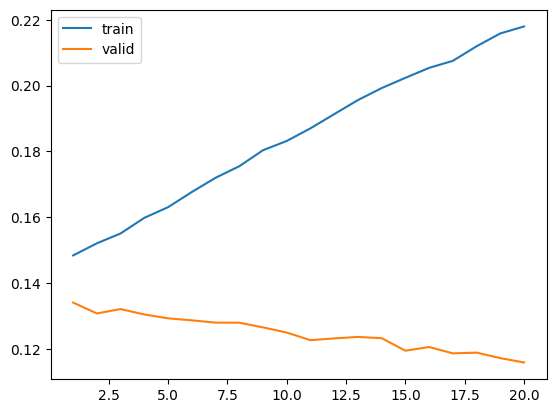

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Entrenamiento
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [52]:
# Guardar modelo entrenado en pkl
with open('./models/modelo_borges_cortazar_0.11.pkl', 'wb') as f:
    pickle.dump(model, f)

In [53]:
# Guardar el tokenizer
with open('./models/tokenizer_borges_cortazar_0.11.pkl', 'wb') as f:
    pickle.dump(model_w2v, f)


In [54]:
# Guardar modelo entrenado en pkl
model.save('./models/modelo_borges_cortazar_0.11',save_format='tf')

INFO:tensorflow:Assets written to: ./models/modelo_borges_cortazar_0.11\assets


INFO:tensorflow:Assets written to: ./models/modelo_borges_cortazar_0.11\assets


### 5 - Predicción de próxima palabra

In [ ]:
# Keras pad_sequences
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
# Si la secuencia de entrada supera al input_seq_len (3) se trunca
# Si la secuencia es más corta se agregna ceros al comienzo

In [28]:
# Se utilizará gradio para ensayar el modelo
# Herramienta poderosa para crear interfaces rápidas para ensayar modelos
# https://gradio.app/
# import sys
# !{sys.executable} -m pip install gradio --quiet

In [55]:
import gradio as gr

def model_response(human_text):

    print("Input: " + human_text)

    # Encodeamos
    # encoded = tok.texts_to_sequences([human_text])[0]

    # Encodeamos la palabra ingresada a vector usando WordToVec
    encoded = []
    for word in human_text.split():
        try:
            encoded.append(model_w2v.wv.key_to_index[word])
        except:
            encoded.append(0)
     
    print("Encoded: " + str(encoded))
    # Si tienen distinto largo
    encoded = pad_sequences([encoded], maxlen=3, padding='pre')
    
    # Predicción softmax
    y_hat = model.predict(encoded).argmax(axis=-1)

    # Debemos buscar en el vocabulario la palabra
    # que corresopnde al indice (y_hat) predicho por le modelo
    out_word = ''
    for word, index in model_w2v.wv.key_to_index.items():
        if index == y_hat:
            out_word = word
            break

    # Agrego la palabra a la frase predicha

    print("Respuesta: " + human_text + ' ' + out_word)

    return human_text + ' ' + out_word

iface = gr.Interface(
    fn=model_response,
    inputs=["textbox"],
    outputs="text",
    layout="vertical")

iface.launch(debug=True)

C:\Users\EZEQUIEL\AppData\Local\Temp\ipykernel_16308\737417435.py:39: GradioDeprecationWarning: `layout` parameter is deprecated, and it has no effect
  iface = gr.Interface(


Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Input: queria llegar rapido a
Encoded: [0, 281, 0, 5]
1/1 [==============================] - 0s 22ms/step
Respuesta: queria llegar rapido a ratos
Input: me llamaron para
Encoded: [16, 4031, 21]
1/1 [==============================] - 0s 21ms/step
Respuesta: me llamaron para que
Input: me llamaron para que
Encoded: [16, 4031, 21, 2]
1/1 [==============================] - 0s 21ms/step
Respuesta: me llamaron para que el
Input: me llamaron para que el
Encoded: [16, 4031, 21, 2, 4]
1/1 [==============================] - 0s 22ms/step
Respuesta: me llamaron para que el maestro
Input: me llamaron para que el maestro
Encoded: [16, 4031, 21, 2, 4, 440]
1/1 [==============================] - 0s 21ms/step
Respuesta: me llamaron para que el maestro iniciaba
Keyboard interruption in main thread... closing server.


### 6 - Generación de secuencias nuevas

In [42]:
def generate_seq(model, tokenizer, seed_text, max_length, n_words):
    """
        Exec model sequence prediction

        Args:
            model (keras): modelo entrenado
            tokenizer (keras tokenizer): tonenizer utilizado en el preprocesamiento
            seed_text (string): texto de entrada (input_seq)
            max_length (int): máxima longitud de la sequencia de entrada
            n_words (int): números de palabras a agregar a la sequencia de entrada
        returns:
            output_text (string): sentencia con las "n_words" agregadas
    """
    output_text = seed_text
	# generate a fixed number of words
    for _ in range(n_words):
		# Encodeamos
        encoded = []
        for word in output_text.split():
            try:
                encoded.append(tokenizer.wv.key_to_index[word])
            except:
                encoded.append(0)

        # encoded = tokenizer.texts_to_sequences([output_text])[0]
		# Si tienen distinto largo
        encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')
		
		# Predicción softmax
        y_hat = model.predict(encoded).argmax(axis=-1)
		# Vamos concatenando las predicciones
        out_word = ''

        # Debemos buscar en el vocabulario la palabra
        # que corresopnde al indice (y_hat) predicho por le modelo
        for word, index in tokenizer.wv.key_to_index.items():
            if index == y_hat:
                out_word = word
                break

		# Agrego las palabras a la frase predicha
        output_text += ' ' + out_word
    return output_text

In [44]:
input_text='un día vine'

generate_seq(model, model_w2v, input_text, max_length=3, n_words=5)

1/1 [==============================] - 0s 21ms/step


'un día vine a la excavación y se'

### 7 - Beam search y muestreo aleatorio

In [45]:
# funcionalidades para hacer encoding y decoding

def encode(text,max_length=3):

    # encoded = tok.texts_to_sequences([text])[0]
    encoded = []
    for word in text.split():
        try:
            encoded.append(model_w2v.wv.key_to_index[word])
        except:
            encoded.append(0)
    encoded = pad_sequences([encoded], maxlen=max_length, padding='pre')

    return encoded

def decode(seq):
    # return tok.sequences_to_texts([seq])
    return ' '.join([model_w2v.wv.index_to_key[i] for i in seq])

In [46]:
from scipy.special import softmax

# función que selecciona candidatos para el beam search
def select_candidates(pred,num_beams,vocab_size,history_probs,history_tokens,temp=1):

  # colectar todas las probabilidades para la siguiente búsqueda
  pred_large = []

  for idx,pp in enumerate(pred):
    pred_large.extend(np.log(pp+1E-10)+history_probs[idx])

  pred_large = np.array(pred_large)

  # criterio de selección
  if (temp == 1):
    idx_select = np.argsort(pred_large)[::-1][:num_beams] # beam search determinista
  else:
    idx_select = np.random.choice(np.arange(pred_large.shape[0]), num_beams, p=softmax(pred_large/temp)) # beam search con muestreo

  # traducir a índices de token en el vocabulario
  new_history_tokens = np.concatenate((np.array(history_tokens)[idx_select//vocab_size],
                        np.array([idx_select%vocab_size]).T),
                      axis=1)

  # devolver el producto de las probabilidades (log) y la secuencia de tokens seleccionados
  return pred_large[idx_select.astype(int)], new_history_tokens.astype(int)


def beam_search(model,num_beams,num_words,input,temp=1):

    # first iteration

    # encode
    encoded = encode(input)

    # first prediction
    y_hat = np.squeeze(model.predict(encoded))

    # get vocabulary size
    vocab_size = y_hat.shape[0] 

    # initialize history
    history_probs = [0]*num_beams
    history_tokens = [encoded[0]]*num_beams

    # select num_beams candidates
    history_probs, history_tokens = select_candidates([y_hat],
                                        num_beams,
                                        vocab_size,
                                        history_probs,
                                        history_tokens,
                                        temp) 

    # beam search loop
    for i in range(num_words-1):

      preds = []

      for hist in history_tokens:

        # actualizar secuencia de tokens
        input_update = np.array([hist[i+1:]]).copy()

        # predicción
        y_hat = np.squeeze(model.predict(input_update)) 

        preds.append(y_hat)

      history_probs, history_tokens = select_candidates(preds,
                                                        num_beams,
                                                        vocab_size,
                                                        history_probs,
                                                        history_tokens,
                                                        temp) 

    return history_tokens

In [49]:
# predicción con beam search
salidas = beam_search(model,num_beams=10,num_words=6,input="un hombre llego", temp=1)

1/1 [==============================] - 0s 23ms/step


In [50]:
# veamos las salidas
for salida in salidas:
  print(decode(salida))


un hombre llego a dormirnos la ceremonia discutirla sorprenderse
un hombre llego a dormirnos la ceremonia discutirla de
un hombre llego a dormirnos la meresunda más natural
un hombre llego a dormirnos la ceremonia de la
un hombre llego a dormirnos la ceremonia discutirla del
un hombre llego a dormirnos la meresunda de la
un hombre llego a dormirnos la meresunda más virtuosa
un hombre llego a dormirnos la ceremonia de las
un hombre llego a ver a su madre y
un hombre llego a dormirnos la meresunda parecía que


## ACLARACIONES

En este Notebook, se corrigieron algunos puntos comentados en clase, como por ejemplo que en las secuencias generadas para entrenar al modelo, se eliminen todas aquellas que refieran al final de una frase y al comienzo de otra, de forma tal que cuando se genera una seuencia donde la ultima palabra target es la ultima palabra de la frase, la proxima secuencia inicia con la primer palabra de la siguiente frase. En otras palabras, todas las secuencias usadas para entrenar al modelo provienen de una frase real y tienen sentido.

El modelo que se encuentra en esta notebook fue entrenado dos veces, por lo cual el grafico del accuracy durante el entrenamiento solo refleja la segunda corrida del entrenamiento, donde se ve que empieza a bajar el accuracy en la validacion.

## CONCLUSIONES

Se realizaron cerca de 100 entrenamientos con distintos hiperparametros y corpus para buscar resultados aceptables, intentando todo lo que se pueda dentro de las capacidades computacionales con las que dipongo en este momento. 

Se probó cambiar el modelo, agregando neuronas, capas, cambiando el tamaño del embedding, el tipo de estructura de SimpleRNN a LSTM o incluso GRU, agregar o quitar dropout, aumentar el tamaño de la secuencia y cambiar de corpus, entre otras pruebas.

Los corpus que se probaron fueron dos, uno que contiene frases de libros de Cortazar, Borges y Bioy Casares, y otro que contiene sentencias de Wikipedia (30.000 secuencias)

La mayoria de los entrenamientos no superaban el 0.1 de accuracy y empezaban a tener overfitting. Los resultados obtenidos de los modelos en la mayoria de los casos no tenian sentido, por lo cual investigue otras formas de hacer funcionar el modelo, lo que me llevó a probar la utilizacion de un embedding pre-entrenado (WordToVect)

Las palabras se tokenizaron con el modelo WordToVect en vez de con Tokenizer y se marcó como Trainable=False la capa de Embeddings del modelo para que esa capa no se entrene.

Con ese modelo se obtuvo un accuracy de 0.116, y empezó a dar resultados interesantes al hacer predicciones de la proxima palabra. Por ejemplo:

```python
Input: me llamaron para <-----------------------------------------------(INPUT)
Encoded: [16, 4031, 21]
1/1 [==============================] - 0s 21ms/step
Respuesta: me llamaron para que <---------------------------------------(OUTPUT)

Input: me llamaron para que <-------------------------------------------(INPUT)
Encoded: [16, 4031, 21, 2]
1/1 [==============================] - 0s 21ms/step
Respuesta: me llamaron para que el <------------------------------------(OUTPUT)

Input: me llamaron para que el <----------------------------------------(INPUT)
Encoded: [16, 4031, 21, 2, 4]
1/1 [==============================] - 0s 22ms/step
Respuesta: me llamaron para que el maestro <----------------------------(OUTPUT)
```
Y en la generacion de multiples palabras, tambien se generaron cosas que tienen sentido, como:

```python
INPUT = "un hombre llego"
OUTPUT = "un hombre llego a ver a su madre y"
```

Parece ser que el punto clave en el entrenamiento es tener un buen modelo que convierta las palabras a vectores para que el modelo, partiendo de esa base, pueda dedicarse a predecir la proxima palabra. Ya que entrenar un modelo que realice ambas tareas juntas (Entrenar la capa de Embeddings y entrenar para predecir la proxima palabra), si no se tiene un corpus suficientemente grande o gran capacidad de computo y mucho tiempo, el resultado que se logra no es bueno.


Si el objetivo del Desafío no era utilizar Embeddings pre-entrenados, dejo subido a este mismo repositorio los otros intentos de entrenamiento de modelos con distintos corpus y distintos modelos.

